In [40]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

## Чтение и знакомство с данными

In [2]:
df_trans = pd.read_excel(r"data\transactions_data.xlsx")
df_trans.head()

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant
0,ff36597c-df41-44a0-9f46-6aa1fe615270,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,2025-01-04 00:02:20,Структурирование капитала,55838.059789,Банковский перевод,North Patrickport,Cheryl Waller
1,0d5263ec-413d-44d9-a9d3-a996e3a56b05,c940f45c-d29b-439a-8fa3-f75018cef528,2025-03-10 17:16:50,Структурирование капитала,37514.809209,Неизвестно,New Zacharyport,Frank Pollard
2,5e9a8978-df1c-483f-a53b-16149c93f11e,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,2025-02-13 19:43:49,Структурирование капитала,21022.146872,Неизвестно,Port Michellemouth,Alexandra Meyer
3,524031ea-56e2-410a-aee2-e8fc6ae3fbc5,NaN,2025-03-02 03:14:10,Финансовое планирование,2313.980219,Неизвестно,Erichaven,Patricia Haas
4,421aaf04-c97d-42ac-b35f-09a56bbaf910,3f43d7bc-37f0-4535-8391-51702d6ff81e,2025-03-18 21:00:36,Структурирование капитала,5636.586955,Неизвестно,Bondstad,Melissa Pena


In [3]:
df_clients = pd.read_json(r"data\clients_data.json")
df_clients.head()

,id,age,gender,net_worth
0,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,41.0,Мужчина,2514729.46
1,c940f45c-d29b-439a-8fa3-f75018cef528,28.0,Мужчина,566568.29
2,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,55.0,Женщина,1896001.28
3,None,38.0,Женщина,4538759.60
4,3f43d7bc-37f0-4535-8391-51702d6ff81e,31.0,Мужчина,4865849.92


## Разберемся с данными из df_trans

#### Обработка пропущенных значений

In [4]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_id    9526 non-null   object 
 1   client_id         9798 non-null   object 
 2   transaction_date  10000 non-null  object 
 3   service           10000 non-null  object 
 4   amount            9540 non-null   float64
 5   payment_method    10000 non-null  object 
 6   city              10000 non-null  object 
 7   consultant        10000 non-null  object 
dtypes: float64(1), object(7)
memory usage: 625.1+ KB


In [5]:
df_trans.isnull().sum()

transaction_id      474
client_id           202
transaction_date      0
service               0
amount              460
payment_method        0
city                  0
consultant            0
dtype: int64

transaction_id и client_id уникальные значения, которые должны выдаваться при создании транзакции и регистрации клиента соответственно, поэтому удалим строки с пропущенными значениями из DataFrame, а удаленные строки запишем в отдельные файлы, чтобы в последующем мы могли передать их на анализ отделам, занимающимися данными вопросами.

In [6]:
df_trans_transId_null = df_trans[df_trans['transaction_id'].isna()]
df_trans_transId_null.to_excel("data\\problem_data\\transaction_id_Null.xlsx", index = False)

In [7]:
df_trans_clientId_null = df_trans[df_trans['client_id'].isna()]
df_trans_clientId_null.to_excel("data\\problem_data\\client_id_Null.xlsx", index = False)

In [8]:
df_trans = df_trans.dropna(subset=["transaction_id", "client_id"])
df_trans.isnull().sum()

transaction_id        0
client_id             0
transaction_date      0
service               0
amount              426
payment_method        0
city                  0
consultant            0
dtype: int64

также присваивать в amount нельзя какие-то случайные значения, или 0 нельзя, поэтому удалим данные строки

In [9]:
df_trans_amount_null = df_trans[df_trans['amount'].isna()]
df_trans_amount_null.to_excel("data\\problem_data\\amount_Null.xlsx", index = False)

In [10]:
df_trans = df_trans.dropna(subset=['amount'])
print(f"Строк с NaN значениями в df_trans: {df_trans.isnull().sum().sum()}")

Строк с NaN значениями в df_trans: 0


#### Проверка данных на корректность и их обработка

Начнем проверку на корректность данных, для начала сумму транзакции (должна быть больше 0).

In [11]:
df_trans[df_trans["amount"] <= 0]

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant


***Данные сумм транзакций корректны***

Переведем даты в тип datetime и проверим их на корректность

In [12]:
df_trans['transaction_date'] = pd.to_datetime(df_trans['transaction_date'], errors='coerce')
df_data_error = df_trans[df_trans['transaction_date'] >= datetime.now()]
df_trans = df_trans[df_trans['transaction_date'] < datetime.now()]

df_data_error.head()

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant


***Все данные с датами транзакций корректны***

Проверим способы оплаты и тип оказанной финансовой услуги на корректность с логической точки зрения

In [13]:
df_trans["payment_method"].unique()

array(['Банковский перевод', 'Неизвестно', 'Кредитная карта',
       'Криптовалюта', 'Наличные'], dtype=object)

In [14]:
df_trans["service"].unique()

array(['Структурирование капитала', 'Инвестиционное консультирование',
       'Неизвестная услуга', 'Налоговое планирование',
       'Управление активами', 'Финансовое планирование'], dtype=object)

***Данные корректны***

## Разберемся с df_clients

#### Обработка пропущенных значений

In [15]:
df_clients.isnull().sum()

id              1
age           983
gender       3319
net_worth     475
dtype: int64

Наиболее важно поле id для индификации клиента, удалим поле с пропущенным значением (либо можно было бы заполнить уникальным значением и хешировать)

In [16]:
df_clients = df_clients.dropna(subset=["id"])

Остальные значения по-моему мнению могут быть Nan так как они не так важны

#### Проверка данных на корректность и их обработка

##### Прверим возраст на корректность

In [17]:
df_clients[df_clients["age"] <= 0]

,id,age,gender,net_worth


In [18]:
df_clients[df_clients["age"] >= 100]

,id,age,gender,net_worth


***Возраст корректен***

##### Проверим пол на корректность

In [19]:
df_clients["gender"].unique()

array(['Мужчина', 'Женщина', None], dtype=object)

***Пол корректен***

##### Чистая стоимость активов клиента

In [20]:
df_clients[df_clients["net_worth"] < 0]

,id,age,gender,net_worth


***корректно***

## Решение задач

#### 2. Анализ данных

##### Определить топ-5 наиболее популярных услуг по количеству заказов.

In [21]:
top_services = df_trans['service'].value_counts().head(5)
service_names = top_services.index.tolist()
service_counts = top_services.values.tolist()
top5_famous_service = dict()
print("Топ 5 самых популярных услуг", '\n')
for key, val in zip(service_names, service_counts):
    top5_famous_service[key] = val
    print(f"Услуга: {key}, Количество заказов: {val}")

Топ 5 самых популярных услуг 

Услуга: Инвестиционное консультирование, Количество заказов: 1956
Услуга: Управление активами, Количество заказов: 1606
Услуга: Финансовое планирование, Количество заказов: 1242
Услуга: Налоговое планирование, Количество заказов: 1218
Услуга: Структурирование капитала, Количество заказов: 1196


##### Рассчитать среднюю сумму транзакций по каждому городу.

In [22]:
df_trans.groupby(by="city")["amount"].sum().sort_values(ascending = False).head(5).to_dict()

{'Неизвестный город': 15454021.164274579,
 'Port Michellemouth': 9714997.880923014,
 'New Tommyborough': 9054069.503499499,
 'Kaneburgh': 9050556.916716697,
 'Johnsonfort': 8835446.259065658}

Так как неизвестный город наверное не предполагался, то нужный нам ***Port Michellemouth*** с суммой транзакций около ***9714997.8***

##### Вычислить процент транзакций по способам оплаты (наличные, банковский перевод и т. д.). 

In [23]:
payment_counts = df_trans['payment_method'].value_counts(normalize=True) * 100
payment_counts = payment_counts.round(2)
print(payment_counts)

payment_method
Кредитная карта       40.04
Банковский перевод    34.59
Неизвестно            10.15
Наличные               9.96
Криптовалюта           5.27
Name: proportion, dtype: float64


##### Рассчитать выручку за последний месяц (по сумме amount)

In [24]:
sum_trans_last_month = df_trans[df_trans["transaction_date"] >= datetime.now() - timedelta(days=60)]["amount"].sum().round()
print(f"Вырочка за последний месяц составила: {sum_trans_last_month}")

Вырочка за последний месяц составила: 133623483.0


#### 3. Объединение данных

##### Объединить транзакции с клиентскими данными (по id). 

In [25]:
df_merged = pd.merge(df_trans, df_clients, left_on='client_id', right_on = 'id', how='left')
df_merged.head()

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant,id,age,gender,net_worth
0,ff36597c-df41-44a0-9f46-6aa1fe615270,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,2025-01-04 00:02:20,Структурирование капитала,55838.059789,Банковский перевод,North Patrickport,Cheryl Waller,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,41.0,Мужчина,2514729.46
1,0d5263ec-413d-44d9-a9d3-a996e3a56b05,c940f45c-d29b-439a-8fa3-f75018cef528,2025-03-10 17:16:50,Структурирование капитала,37514.809209,Неизвестно,New Zacharyport,Frank Pollard,c940f45c-d29b-439a-8fa3-f75018cef528,28.0,Мужчина,566568.29
2,5e9a8978-df1c-483f-a53b-16149c93f11e,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,2025-02-13 19:43:49,Структурирование капитала,21022.146872,Неизвестно,Port Michellemouth,Alexandra Meyer,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,55.0,Женщина,1896001.28
3,421aaf04-c97d-42ac-b35f-09a56bbaf910,3f43d7bc-37f0-4535-8391-51702d6ff81e,2025-03-18 21:00:36,Структурирование капитала,5636.586955,Неизвестно,Bondstad,Melissa Pena,3f43d7bc-37f0-4535-8391-51702d6ff81e,31.0,Мужчина,4865849.92
4,822d5795-4f08-4a7a-9692-7f5863945bdf,900f7d6b-ee7f-49e6-ae9f-e5ea9e04ab4c,2025-02-21 21:50:30,Инвестиционное консультирование,85575.773285,Кредитная карта,West Jaymouth,Harold Gibson,900f7d6b-ee7f-49e6-ae9f-e5ea9e04ab4c,59.0,Женщина,3992281.84


##### Создать новую колонку с уровнями активов. 

In [28]:
def asset_level_f(val):
    if val < 10**5:
        return "Низкий капитал"
    elif val < 10 ** 6:
        return "Средний капитал"
    else:
        return "Высокий капитал"

df_merged["asset_level"] = df_merged["net_worth"].apply(asset_level_f)
df_merged.head()

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant,id,age,gender,net_worth,asset_level
0,ff36597c-df41-44a0-9f46-6aa1fe615270,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,2025-01-04 00:02:20,Структурирование капитала,55838.059789,Банковский перевод,North Patrickport,Cheryl Waller,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,41.0,Мужчина,2514729.46,Высокий капитал
1,0d5263ec-413d-44d9-a9d3-a996e3a56b05,c940f45c-d29b-439a-8fa3-f75018cef528,2025-03-10 17:16:50,Структурирование капитала,37514.809209,Неизвестно,New Zacharyport,Frank Pollard,c940f45c-d29b-439a-8fa3-f75018cef528,28.0,Мужчина,566568.29,Средний капитал
2,5e9a8978-df1c-483f-a53b-16149c93f11e,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,2025-02-13 19:43:49,Структурирование капитала,21022.146872,Неизвестно,Port Michellemouth,Alexandra Meyer,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,55.0,Женщина,1896001.28,Высокий капитал
3,421aaf04-c97d-42ac-b35f-09a56bbaf910,3f43d7bc-37f0-4535-8391-51702d6ff81e,2025-03-18 21:00:36,Структурирование капитала,5636.586955,Неизвестно,Bondstad,Melissa Pena,3f43d7bc-37f0-4535-8391-51702d6ff81e,31.0,Мужчина,4865849.92,Высокий капитал
4,822d5795-4f08-4a7a-9692-7f5863945bdf,900f7d6b-ee7f-49e6-ae9f-e5ea9e04ab4c,2025-02-21 21:50:30,Инвестиционное консультирование,85575.773285,Кредитная карта,West Jaymouth,Harold Gibson,900f7d6b-ee7f-49e6-ae9f-e5ea9e04ab4c,59.0,Женщина,3992281.84,Высокий капитал


##### Провести анализ по уровням активов и определить, какие категории клиентов приносят наибольшую выручку. 

In [39]:
dict_amount_assetL_float = df_merged.groupby("asset_level")["amount"].sum().sort_values().to_dict()
dict_amount_assetL_int = {key: round(val) for key, val in dict_amount_assetL_float.items()}
sum_amount = sum(dict_amount_assetL_int.values())
dict_amount_assetL_normalize = {key: f"{round(val / sum_amount * 100, 1)}%" for key, val in dict_amount_assetL_int.items()}
print(dict_amount_assetL_int)
print(dict_amount_assetL_normalize)

{'Низкий капитал': 6813887, 'Средний капитал': 65392167, 'Высокий капитал': 326350355}
{'Низкий капитал': '1.7%', 'Средний капитал': '16.4%', 'Высокий капитал': '81.9%'}


Как мы видим, наибольшую выручку приносят клиенты с высоким капиталом (почти 82%), примерно в 5 раз меньше клиенты со средним капиталом (16.4%) и всего 1.7% клиенты с низким капиталом

#### 4. Визуализация

##### Построить распределение сумм транзакций.

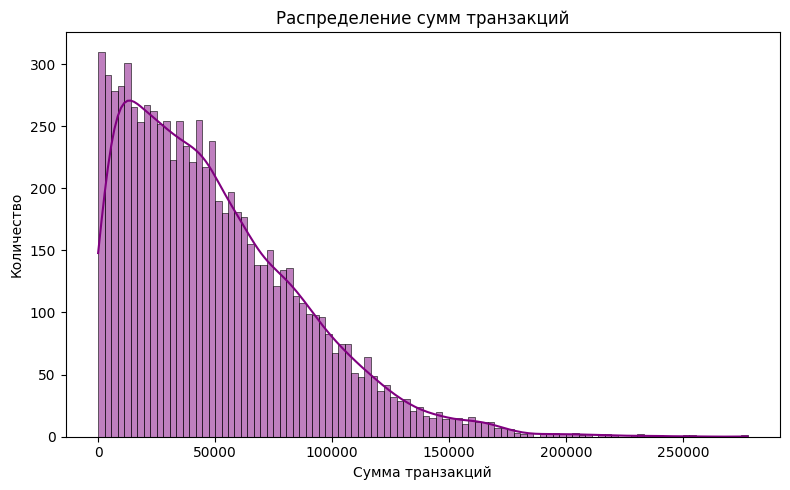

In [63]:
plt.figure(figsize= (8, 5))
sns.histplot(data = df_merged["amount"], bins = 100, kde=True, color = "purple", )
plt.ylabel("Количество")
plt.xlabel("Сумма транзакций")
plt.title("Распределение сумм транзакций")
plt.tight_layout()
plt.show()

##### Создать диаграмму выручки по услугам.

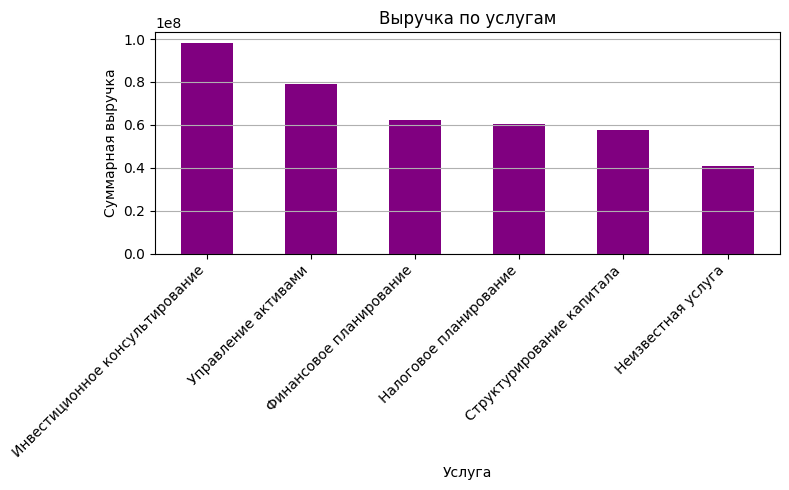

In [64]:
data_amount_service = df_merged.groupby('service')['amount'].sum().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
data_amount_service.plot(kind='bar', color='purple')
plt.title('Выручка по услугам')
plt.xlabel('Услуга')
plt.ylabel('Суммарная выручка')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


##### Построить график зависимости средней суммы транзакции от возраста клиентов.

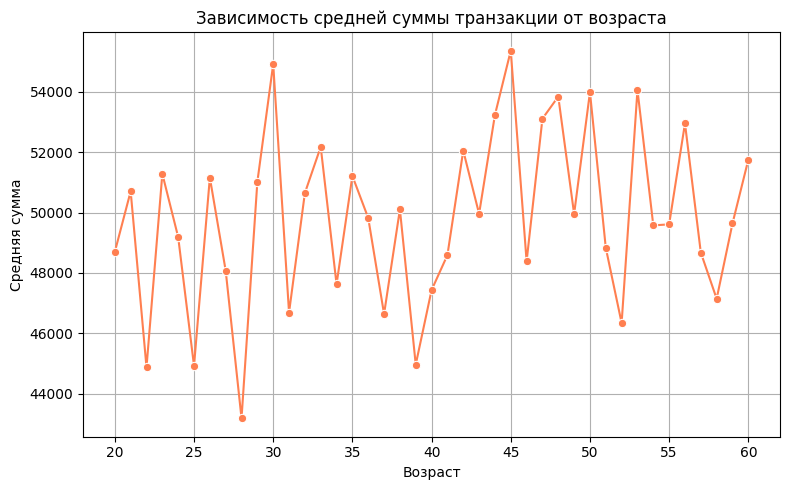

In [84]:
data_amount_age = df_merged.groupby("age")["amount"].mean()

plt.figure(figsize=(8, 5))
sns.lineplot(x=data_amount_age.index, y=data_amount_age, marker='o', color='coral')
plt.title('Зависимость средней суммы транзакции от возраста')
plt.xlabel('Возраст')
plt.ylabel('Средняя сумма')
plt.grid(True)
plt.tight_layout()
plt.show()


#### 5. Прогнозирование.

Импорт библиотек

In [ ]:
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import root_mean_squared_error